### 多输入通道

假设输入数据的通道数为$c_i$,那么卷积核的输入通道数同样为$c_i$.设卷积核窗口形状为$k_h$*$k_w$，则会得到一个$c_i*k_h*k_w$的卷积核。具体过程如下图所以:
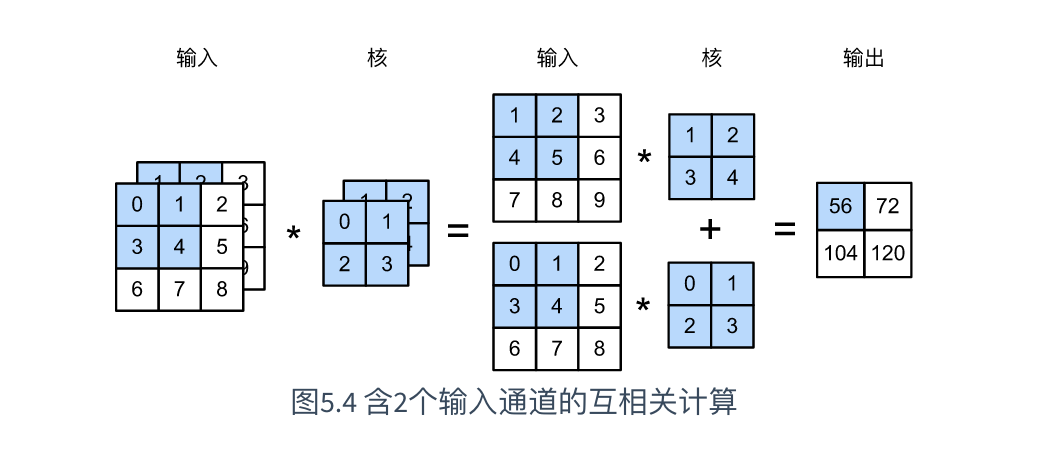

### 多输出通道

假设卷积核输入通道数和输出通道数分别为$c_i$和$c_o$,高和宽分别为$k_h$和$k_w$。如果希望得到含多个通道的输出，卷积核的形状为$c_o*c_i*k_h*k_w$.

在做互相关运算时，每个输出通道上的结果由卷积核在该输出通道上的卷积核数组与整个输入数组计算而来。

### 简单实现

In [1]:
import torch
from torch import nn

def corr2d(X,K):
    h,w=K.shape
    Y=torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1),dtype=torch.float)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j]=(X[i:i+h,j:j+w]*K).sum()
    return Y

In [2]:
#多输入通道
def corr2d_multi_in(X,K):
    res=corr2d(X[0,:,:],K[0,:,:])
    for i in range(1,X.shape[0]):
        res+=corr2d(X[i,:,:],K[i,:,:])
    return res

In [3]:
#多输出通道
#利用torch.stack来拼接
def corr2d_multi_in_out(X,K):
    return torch.stack([corr2d_multi_in(X,k) for k in K])

In [5]:
#输入通道为3，输出通道为3
X=X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])
K=torch.stack([K,K+1,K+2])
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 1x1卷积层

**由于1x1卷积层不涉及相邻元素之间的运算，其主要计算发生在通道维度上，所以1x1卷积层的作用与全连接层等价**

**1x1卷积层通常用来调整网络层之间的通道数，并控制模型复杂度。**

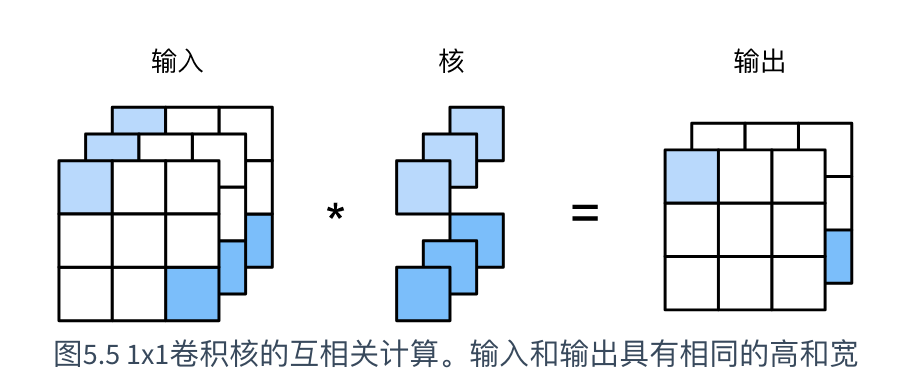

In [6]:
#简单实现
def corr2d_multi_in_out1x1(X,K):
    c_i,h,w=X.shape
    c_o=K.shape[0]
    X=X.view(c_i,h*w)
    K=K.view(c_o,c_i)
    Y=torch.mm(K,X) #权利连接层的矩阵乘法
    return Y.view(c_o,h,w)

In [7]:
X=torch.rand(3,3,3)
K=torch.rand(2,3,1,1)

Y1=corr2d_multi_in_out1x1(X,K)
Y2=corr2d_multi_in_out(X,K)

(Y1-Y2).norm().item() <1e-6

True